In [ ]:
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install pandas
!pip install tensorflow
!pip install matplotlib

In [ ]:
!pip install nltk
!python -m nltk.downloader -f stopwords
!python -m nltk.downloader -f wordnet
!pip install keras_preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import f1_score
import re
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/CSE 440 Project/IMDB Dataset.csv')

In [ ]:
dataset['sentiment']=dataset['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
dataset.sample(10)

,review,sentiment
44754,Some of the reviewers of this film were extrem...,0
4286,This depiction of forlorn Japanese forces in t...,1
9623,This movie is funny in more ways than one. It'...,1
36847,I was absolutely blown away by John Cassavetes...,1
27195,Think of this film as a Saturday morning live-...,0
3850,Once again Bronson's talent is mostly wasted o...,0
47623,"""The Plainsman"" represents the directorial pro...",1
22331,This is a Japanese film but there is quite a b...,0
17109,Plot is not worth discussion even if it hints ...,0
12326,I've read all the complimentary posts on this ...,0


# TASK 1

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset['review'])
y = dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = logistic_regression.predict(X_test)


In [ ]:
report = classification_report(y_test, y_pred)
logistic_f1 = f1_score(y_test, y_pred)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = multinomial_nb.predict(X_test)

In [ ]:
report = classification_report(y_test, y_pred)
Multinomial_f1 = f1_score(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4961
           1       0.88      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



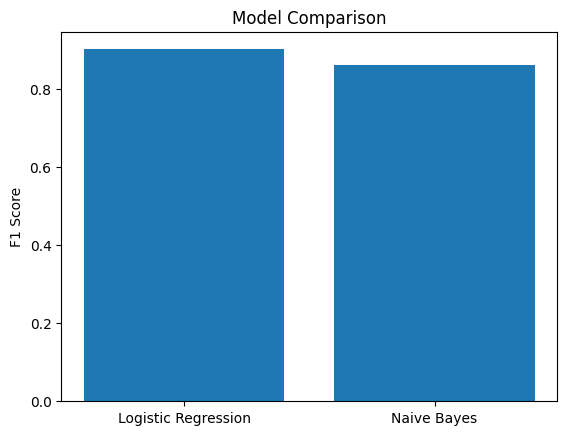

In [ ]:
plt.bar(['Logistic Regression', 'Naive Bayes'], [logistic_f1, Multinomial_f1])
plt.ylabel('F1 Score')
plt.title('Model Comparison')
plt.show()

We can clearly see that F1 score of Logistic Regression is more than Naive Bayes. While Logistic Regression has a F1 score of 0.90 Naive Bayes has an accuracy of 0.86. So Logistic Regression is better here.

# TASK 2

In [ ]:
train_data, temp_data, train_labels, temp_labels = train_test_split(dataset['review'], dataset['sentiment'], test_size=0.3, random_state=42)
test_data, val_data, test_labels, val_labels = train_test_split(temp_data, temp_labels, test_size=0.333, random_state=42)

In [ ]:
reviews_tokenizer = Tokenizer()
reviews_tokenizer.fit_on_texts(train_data)
word_index_map = reviews_tokenizer.word_index

In [ ]:
train_data=reviews_tokenizer.texts_to_sequences(train_data)
test_data=reviews_tokenizer.texts_to_sequences(test_data)
val_data=reviews_tokenizer.texts_to_sequences(val_data)
train_data=pad_sequences(train_data)
test_data=pad_sequences(test_data)
val_data=pad_sequences(val_data)

In [ ]:
glove_embeddings = {}
with open('/content/drive/MyDrive/CSE 440 Project/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [ ]:
embedding_weights = np.zeros((len(word_index_map) + 1, 100))
for word, i in word_index_map.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_weights[i] = embedding_vector

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(len(word_index_map) + 1, 100, weights=[embedding_weights], trainable=False))
rnn_model.add(LSTM(64))
rnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=25, batch_size=150)

# Evaluate the model
loss, accuracy = rnn_model.evaluate(test_data, test_labels)
print(f'Test Accuracy: {accuracy}')

Epoch 1/25
234/234 [==============================] - 32s 104ms/step - loss: 0.5266 - accuracy: 0.7353 - val_loss: 0.4390 - val_accuracy: 0.8024
Epoch 2/25
234/234 [==============================] - 22s 95ms/step - loss: 0.4266 - accuracy: 0.8081 - val_loss: 0.4175 - val_accuracy: 0.8174
Epoch 3/25
234/234 [==============================] - 23s 99ms/step - loss: 0.3789 - accuracy: 0.8329 - val_loss: 0.3589 - val_accuracy: 0.8452
Epoch 4/25
234/234 [==============================] - 24s 102ms/step - loss: 0.3447 - accuracy: 0.8504 - val_loss: 0.3497 - val_accuracy: 0.8539
Epoch 5/25
234/234 [==============================] - 23s 98ms/step - loss: 0.3140 - accuracy: 0.8673 - val_loss: 0.3151 - val_accuracy: 0.8681
Epoch 6/25
234/234 [==============================] - 22s 96ms/step - loss: 0.2969 - accuracy: 0.8766 - val_loss: 0.3052 - val_accuracy: 0.8699
Epoch 7/25
234/234 [==============================] - 23s 100ms/step - loss: 0.2824 - accuracy: 0.8832 - val_loss: 0.3336 - val_accura

In [ ]:
# Generate predictions for the test set
probabilities = rnn_model.predict(test_data)
probabilities = probabilities.flatten()
probabilities = np.where(probabilities > 0.5, 1, 0)
print(classification_report(test_labels,probabilities))

313/313 [==============================] - 8s 24ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4920
           1       0.89      0.90      0.89      5085

    accuracy                           0.89     10005
   macro avg       0.89      0.89      0.89     10005
weighted avg       0.89      0.89      0.89     10005



The F1 score of RNN model is 0.89. The F1 score of the Logistic Regression and Multinomial Naive Bayes is 0.90 and 0.86 respectively. So the highest F1 score is of Logistic Regression and second highest is RNN model and Multinomial NB is in Last place. So Logistic Regression is the best model for our task.